# 1. 색상 추출 데이터 전처리

In [1]:
import pandas as pd
# 원본 데이터 읽기
test = pd.read_csv("test색상검출완료.csv", header=None, names=["Label", "RGB"])
train = pd.read_csv("train색상검출완료.csv", header=None, names=["Label", "RGB"])
valid = pd.read_csv("valid색상검출완료.csv", header=None, names=["Label", "RGB"])

test

,Label,RGB
0,0.0,"(56, 47, 30)"
1,1.0,"(47, 52, 48)"
2,0.0,"(150, 194, 191)"
3,1.0,"(57, 46, 35)"
4,0.0,"(117, 138, 112)"
...,...,...
165,1.0,"(30, 38, 41)"
166,0.0,"(210, 86, 16)"
167,1.0,"(141, 130, 109)"
168,0.0,"(24, 30, 26)"


In [2]:
train

,Label,RGB
0,0.0,"(103, 109, 101)"
1,1.0,"(17, 27, 28)"
2,0.0,"(176, 182, 181)"
3,1.0,"(47, 51, 47)"
4,0.0,"(90, 120, 142)"
...,...,...
959,1.0,"(74, 85, 86)"
960,0.0,"(72, 77, 88)"
961,1.0,"(119, 137, 139)"
962,0.0,"(81, 77, 68)"


In [3]:
valid

,Label,RGB
0,0.0,"(185, 188, 190)"
1,1.0,"(97, 98, 88)"
2,0.0,"(120, 200, 206)"
3,1.0,"(120, 119, 118)"
4,0.0,"(163, 161, 155)"
...,...,...
293,1.0,"(127, 64, 53)"
294,0.0,"(36, 100, 66)"
295,1.0,"(78, 92, 88)"
296,0.0,"(142, 140, 141)"


### 일부 인덱스에서는 상의 또는 하의 데이터가 없는 경우가 있기 때문에 상의를 의미하는 0 뒤에 하의를 의미하는 1이 있는 경우만 남긴다.

In [4]:
# 0 뒤에 1이 있는 경우만 남기기
test1 = test[test["Label"].eq(1.0) | test["Label"].shift(-1).eq(1.0)].reset_index(drop=True)
train1 = train[train["Label"].eq(1.0) | train["Label"].shift(-1).eq(1.0)].reset_index(drop=True)
valid1 = valid[valid["Label"].eq(1.0) | valid["Label"].shift(-1).eq(1.0)].reset_index(drop=True)

In [5]:
# 상의와 하의 데이터프레임 나누기
test_tops = test1[test1["Label"] == 0.0].reset_index(drop=True)
test_bottoms = test1[test1["Label"] == 1.0].reset_index(drop=True)

train_tops = train1[train1["Label"] == 0.0].reset_index(drop=True)
train_bottoms = train1[train1["Label"] == 1.0].reset_index(drop=True)

valid_tops = valid1[valid1["Label"] == 0.0].reset_index(drop=True)
valid_bottoms = valid1[valid1["Label"] == 1.0].reset_index(drop=True)


# tops 데이터프레임의 열 이름을 "TOP_RGB"로 변경
test_tops = test_tops.rename(columns={"RGB": "TOP_RGB"})
test_bottoms = test_bottoms.rename(columns={"RGB": "BOTTOM_RGB"})

train_tops = train_tops.rename(columns={"RGB": "TOP_RGB"})
train_bottoms = train_bottoms.rename(columns={"RGB": "BOTTOM_RGB"})

valid_tops = valid_tops.rename(columns={"RGB": "TOP_RGB"})
valid_bottoms = valid_bottoms.rename(columns={"RGB": "BOTTOM_RGB"})


In [6]:
# 상의와 하의를 번갈아가며 재배치
test_result = pd.concat([test_tops["TOP_RGB"], test_bottoms["BOTTOM_RGB"]], axis=1)
train_result = pd.concat([train_tops["TOP_RGB"], train_bottoms["BOTTOM_RGB"]], axis=1)
valid_result = pd.concat([valid_tops["TOP_RGB"], valid_bottoms["BOTTOM_RGB"]], axis=1)



In [7]:
# 데이터프레임 합치기
result = pd.concat([train_result, test_result, valid_result], ignore_index=True)

result.to_csv("최종 csv")
result

,TOP_RGB,BOTTOM_RGB
0,"(103, 109, 101)","(17, 27, 28)"
1,"(176, 182, 181)","(47, 51, 47)"
2,"(90, 120, 142)","(51, 74, 90)"
3,"(184, 187, 181)","(85, 87, 85)"
4,"(92, 89, 90)","(181, 163, 122)"
...,...,...
707,"(69, 74, 77)","(185, 183, 159)"
708,"(33, 34, 42)","(82, 80, 87)"
709,"(109, 107, 98)","(127, 64, 53)"
710,"(36, 100, 66)","(78, 92, 88)"


# 2. 데이터 학습

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 변환 함수
def convert_to_numeric(data):
    # RGB 값들을 0에서 1 사이의 실수 값으로 정규화
    # eval 함수를 사용하여 문자열 형태의 RGB 값을 파이썬 리스트로 변환
    return np.array([np.array(eval(rgb)) / 255.0 for rgb in data])

# X와 y 설정
# 'TOP_RGB'와 'BOTTOM_RGB' 열의 데이터를 숫자 형태로 변환하여 X와 y로 나눔
X = convert_to_numeric(result['TOP_RGB'].tolist())
y = convert_to_numeric(result['BOTTOM_RGB'].tolist())

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## LinearRegression

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 모델 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.025590867250718945


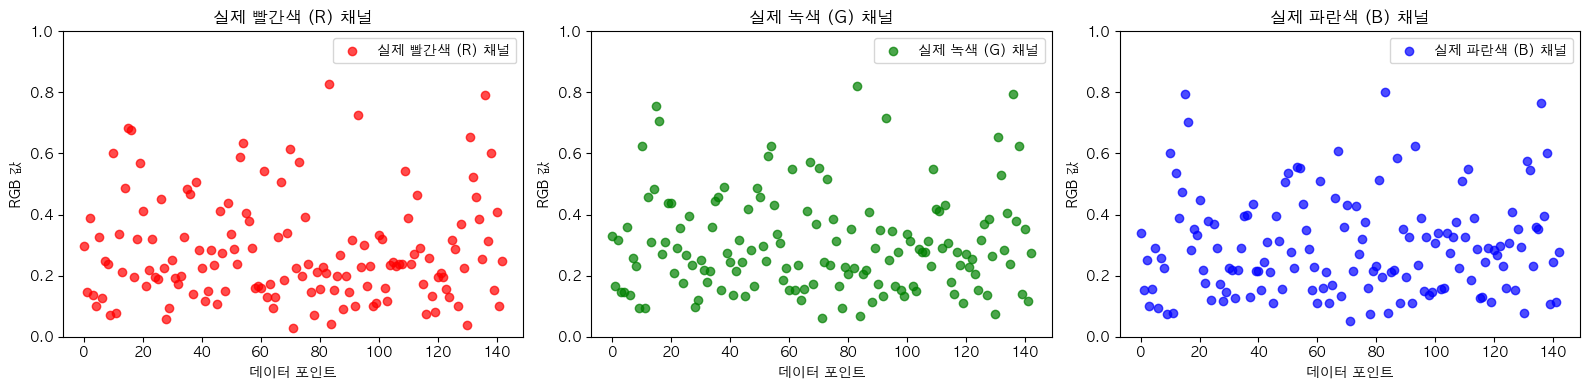

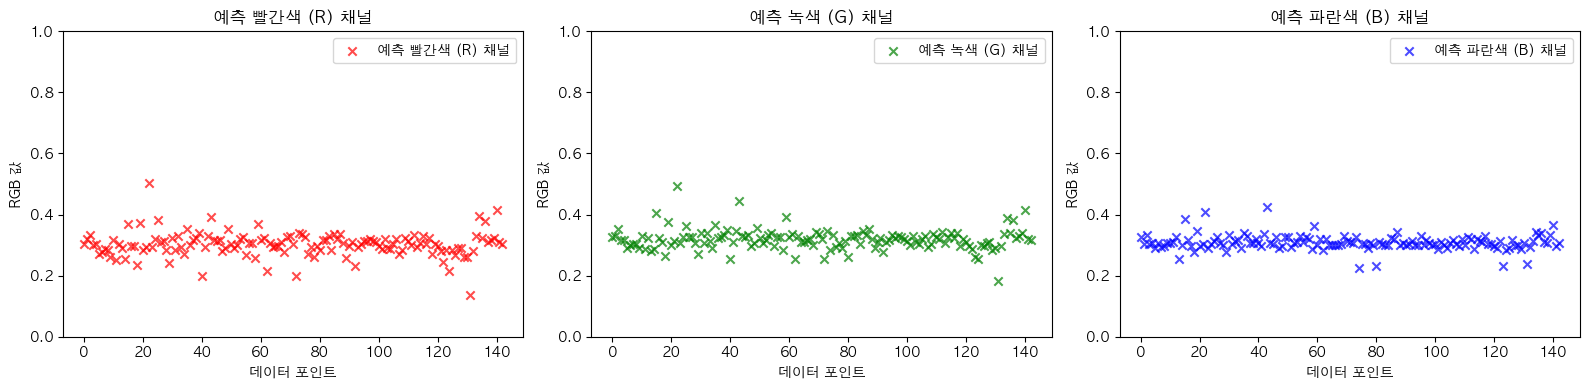

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rc

# 애플고딕 폰트 이름 설정
font_name = "AppleGothic"

# 폰트 매니저에 폰트 등록
rc('font', family=font_name)

# 실제 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_test[:, i], label=f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='o', alpha=0.7)
    plt.title(f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()



# 예측 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_pred[:, i], label=f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='x', alpha=0.7)
    plt.title(f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()


## MLP

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# 모델 선택 및 훈련 (MLP with Dropout and legacy Adam optimizer)
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=3))
model.add(Dropout(0.1))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(units=3))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early Stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')




5/5 [==============================] - 0s 421us/step
Mean Squared Error: 0.02472073240581907


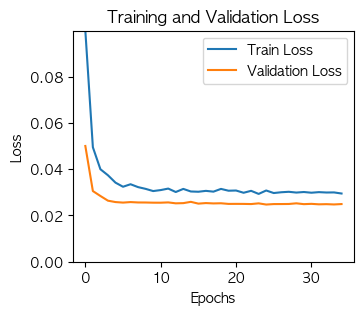

In [12]:
import matplotlib.pyplot as plt

# Your previous code here

# 그래프 그리기
plt.figure(figsize=(8, 3))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# y 축 범위 조절
plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))

plt.show()


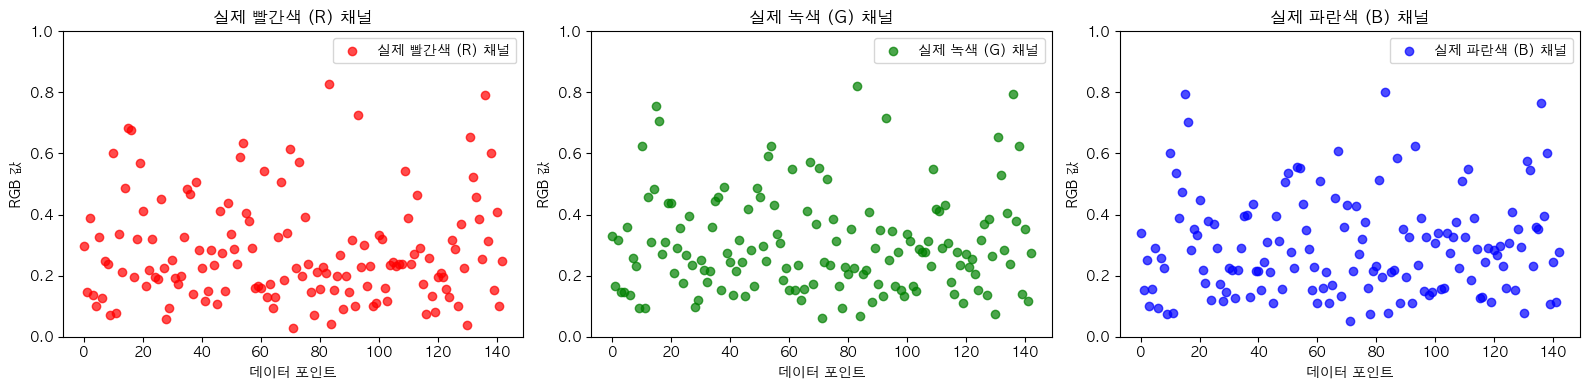

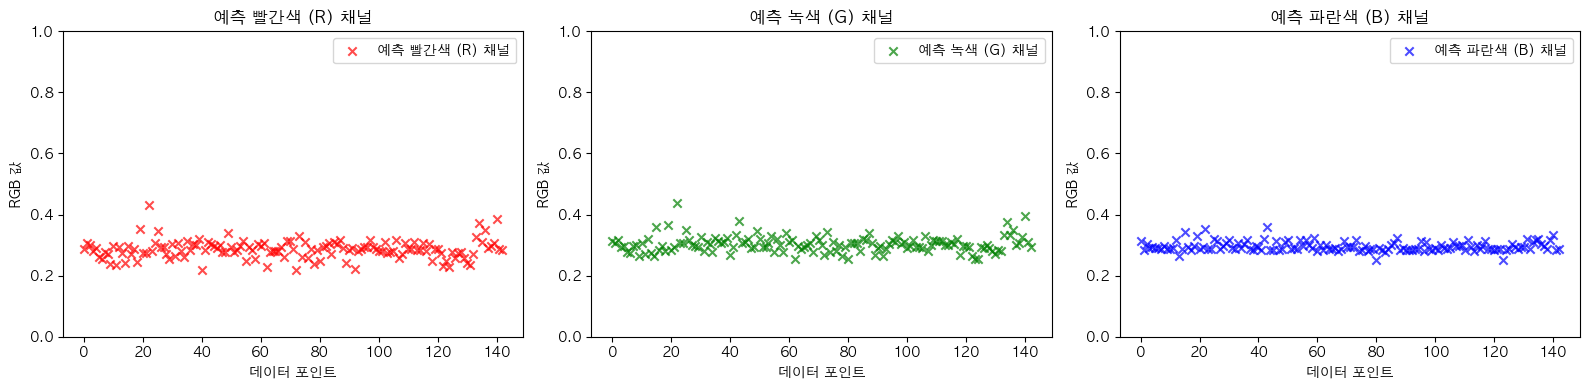

In [13]:
# 실제 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_test[:, i], label=f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='o', alpha=0.7)
    plt.title(f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()



# 예측 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_pred[:, i], label=f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='x', alpha=0.7)
    plt.title(f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()



## RandomForest

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from matplotlib import rc
import matplotlib.pyplot as plt

# RandomForestRegressor 모델 초기화
rf_model = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적의 모델 얻기
best_rf_model = grid_search.best_estimator_

# 테스트 데이터로 예측
y_pred_rf = best_rf_model.predict(X_test)

# 모델 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')




Random Forest Mean Squared Error: 0.008996480242350868


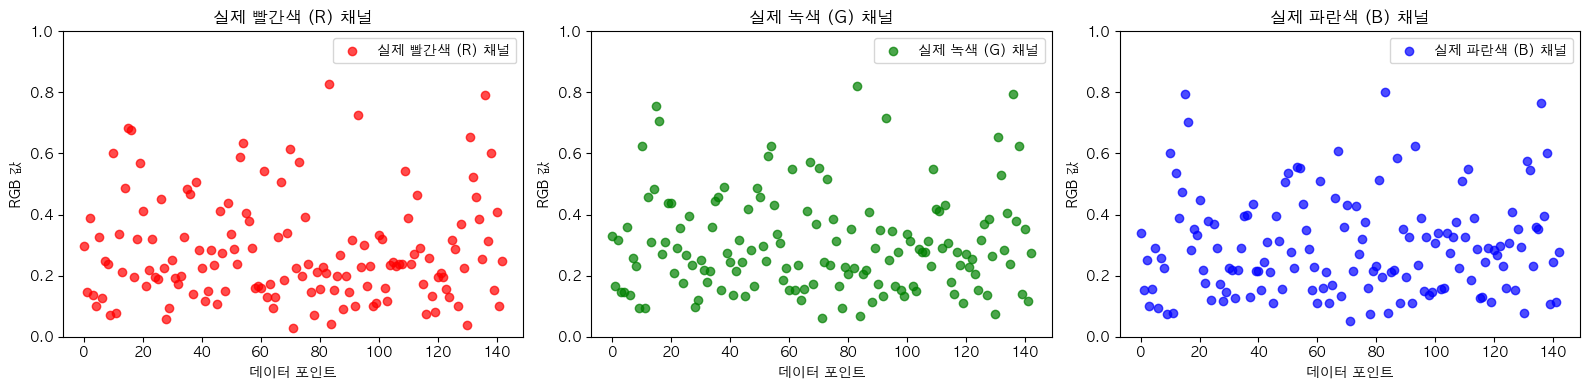

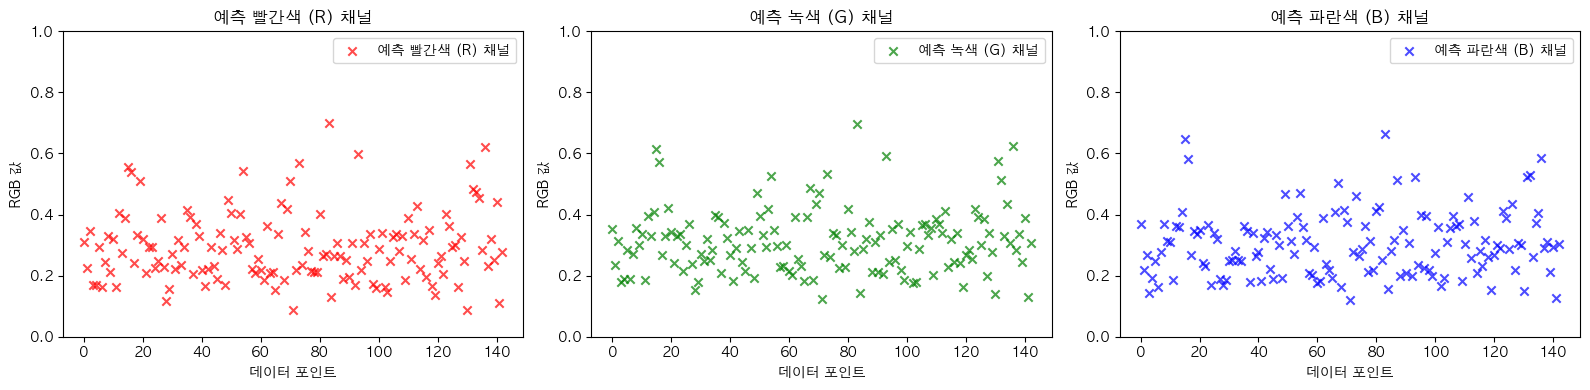

In [15]:
# 실제 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_test[:, i], label=f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='o', alpha=0.7)
    plt.title(f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()

# 예측 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_pred_rf[:, i], label=f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='x', alpha=0.7)
    plt.title(f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()


## K-최근접 이웃 (KNN) 알고리즘을 통한 RGB 예측 성공!!!

**1. 색상 유사성을 고려한 예측:**
- KNN은 새로운 데이터 포인트를 예측할 때, 주변 이웃들의 정보를 활용합니다. RGB 예측에서는 유사한 색상을 가진 이웃들이 더 큰 영향을 미칩니다.

**2. 가중 평균 활용:**
- 'distance' 옵션을 사용하여 가까운 이웃에 더 큰 가중치를 부여합니다. 이는 RGB 값이 가까운 이웃이 예측에 미치는 영향을 강화시킵니다.

**3. 맨해튼 거리 측정:**
- 맨해튼 거리는 RGB 값 간의 색상 차이를 정확하게 측정하는 데 도움을 줍니다. 따라서 모델은 색상 유사성을 더 정확하게 파악하고 예측합니다.

**4. 하이퍼파라미터 튜닝을 통한 최적화:**
- GridSearchCV를 사용하여 최적의 하이퍼파라미터를 찾아내어 모델을 더 효과적으로 조정하였습니다. 이로 인해 모델의 일반화 성능이 향상되었습니다.

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 기본 KNN 모델 생성 및 학습
knn_model_default = KNeighborsRegressor(n_neighbors=5)
knn_model_default.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred_default = knn_model_default.predict(X_test)

# 모델 평가 (기본 모델)
mse_default = mean_squared_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)

print("Default KNN Model:")
print(f'(MSE): {mse_default}')
print(f'R-squared Score: {r2_default}')
print(f'(MAE): {mae_default}')

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_neighbors': [3, 5, 7, 10],  # 원하는 이웃 수로 변경 가능
    'p': [1, 2],  # 1: 맨해튼 거리, 2: 유클리디안 거리
    'weights': ['uniform', 'distance']  # 균일한 가중치 또는 거리에 따른 가중치
}

# KNN 모델 초기화
knn_model_tuned = KNeighborsRegressor()

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(knn_model_tuned, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적의 모델 얻기
best_knn_model = grid_search.best_estimator_

# 테스트 데이터로 예측
y_pred_tuned = best_knn_model.predict(X_test)

# 모델 평가 (튜닝된 모델)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print("\nTuned KNN Model:")
print(f'(MSE): {mse_tuned}')
print(f'R-squared Score: {r2_tuned}')
print(f'(MAE): {mae_tuned}')
print(f'Best Parameters: {grid_search.best_params_}')


Default KNN Model:
(MSE): 0.024152510823791096
R-squared Score: 0.08035181948228531
(MAE): 0.12330545271721739

Tuned KNN Model:
(MSE): 0.006164072428673489
R-squared Score: 0.7646236073060512
(MAE): 0.0262990193188495
Best Parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


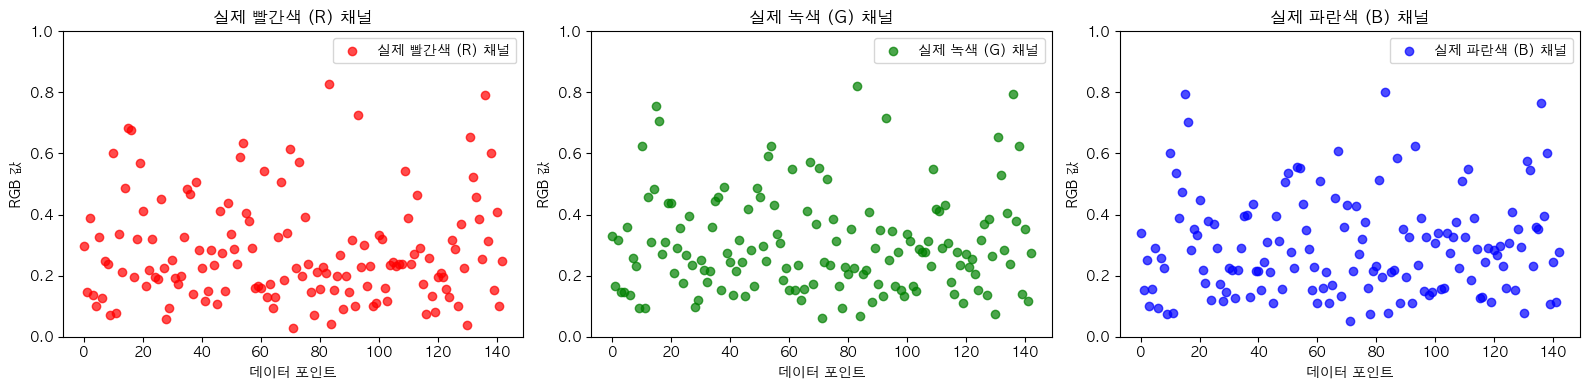

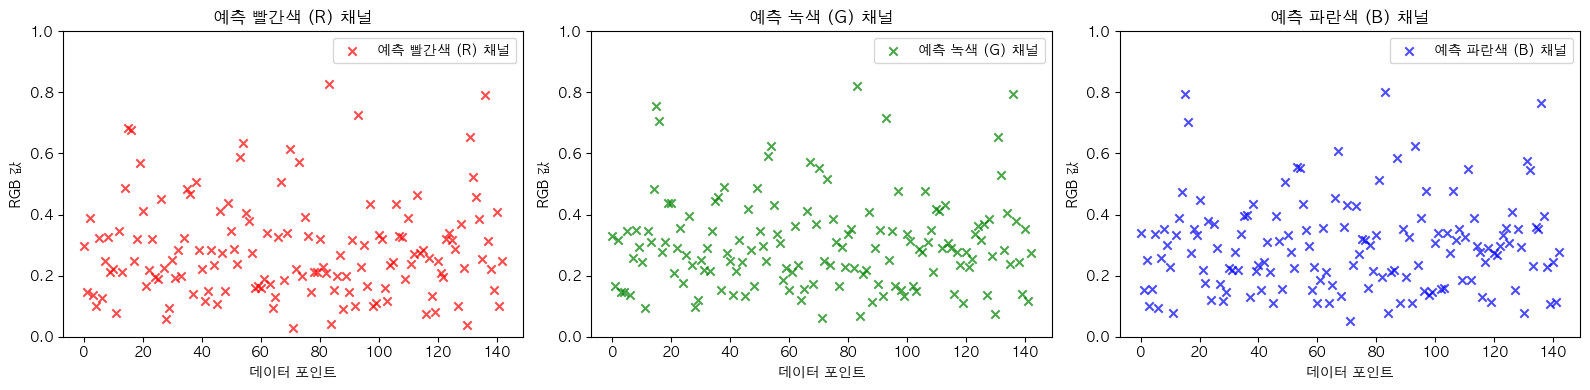

In [19]:
# 실제 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_test[:, i], label=f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='o', alpha=0.7)
    plt.title(f'실제 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()

# 예측 RGB 값 시각화
plt.figure(figsize=(16, 4))

for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(y_test)), y_pred_tuned[:, i], label=f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널', color=color, marker='x', alpha=0.7)
    plt.title(f'예측 {["빨간색 (R)", "녹색 (G)", "파란색 (B)"][i]} 채널')
    plt.xlabel('데이터 포인트')
    plt.ylabel('RGB 값')
    plt.legend()
    # y축 범위 설정
    plt.ylim([0, 1])  # 이 범위는 데이터의 정규화된 값에 따라 조절할 수 있습니다.

plt.tight_layout()
plt.show()

- MSE (Mean Squared Error):
    - 모델이 테스트 데이터에서의 예측이 정확함을 나타내는 지표. 작은 값일수록 좋음.
    - 튜닝된 KNN 모델은 MSE가 0.0061로 매우 낮게 나타남.


- R-squared Score:
    - 예측값이 실제 값의 변동을 얼마나 잘 설명하는지를 나타내는 지표. 1에 가까울수록 좋음.
    - 모델의 R-squared Score는 0.76로 전체 변동 중 76%를 설명함.


- MAE (Mean Absolute Error):
    - 예측값과 실제 값 간의 평균 절대 오차. 작을수록 좋음.
    - 모델의 MAE는 0.0263으로 평균적으로 0.0263의 오차를 갖음.
    - Best Parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

- 최적의 하이퍼파라미터 조합.
    - 10개의 이웃
    - 맨해튼 거리
    - 거리에 따라 가중 평균을 사용.

# 완성한 KNN 모델 저장

In [20]:
import joblib

joblib.dump(best_knn_model, 'tuned_knn_model.joblib')


['tuned_knn_model.joblib']

In [21]:
#import joblib

# 저장된 모델 불러오기
#oaded_model = joblib.load('tuned_knn_model.joblib')

# 불러온 모델을 사용하여 예측 등 수행
#y_pred_loaded = loaded_model.predict(X_test)
